# Chaîne de traitement _data science_.
## _Data wrangling_ avec `python` ([`scipy`](https://www.scipy.org/), [`scikit-learn`](https://scikit-learn.org/)) 


|Auteur|Centre|Modification|
|---|---|---|
|H. Delalin|Arras|2021/02/02|
|P. Halftermeyer|Orléans|2018/11/17|

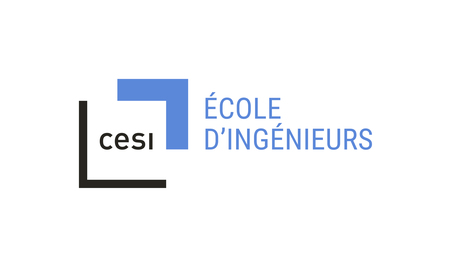

Nous allons essayer, dans le cadre de ce notebook, de prendre en main un jeu de données réel depuis l'import automatisé des fichers jusqu'à la préparation en vue d'alimenter un algorithme de _ML_.

Le _dataset_ présente des données immobilières californiennes. Il compte des variables telles que la population, le salaire médian, le prix moyen d'un logement, _etc_. Et ce pour chaque _block group_ (le _block group_ est la la plus petite division administrative aux Etats-Unis - entre 500 et 5000 personnes).

### Objectifs

On cherchera à mettre au point un modèle de prédiction du prix médian d'un logement en fonction des autres informations. C'est clairement un problème [_supervisé_](https://fr.wikipedia.org/wiki/Apprentissage_supervis%C3%A9) de [_régression multivarié_](https://fr.wikipedia.org/wiki/R%C3%A9gression_lin%C3%A9aire_multiple).

### Mesure de performance

Elle n'interviendra que dans le notebook suivant, celà dit, il convient d'avoir une idée des objectifs dès le début de projet. 

On s'intéressera à terme à la minimisation de la [_root mean square error (RMSE)_](https://en.wikipedia.org/wiki/Root-mean-square_deviation) et/ou de à la [_mean absolute error (MAE)_](https://en.wikipedia.org/wiki/Mean_absolute_error) de notre modèle :

$$
\newcommand\x{\mathbf{x}}
\newcommand\X{\mathbf{X}}
\newcommand\y{\mathbf{y}}
\newcommand\Y{\mathbf{Y}}
\newcommand\RMSE{\text{RMSE}}
\newcommand\MAE{\text{MAE}}
$$
$$
\RMSE(\X,h)=\sqrt{\frac{1}{m}\sum_{i=1}^{m}{(h(\x^{(i)})-y^{(i)})^2}}
$$

$$
\MAE(\X,h)=\frac{\sum_{i=1}^{m}{\lvert h(\x^{(i)})-y^{(i)})\rvert}}{m}
$$

$h$ étant la fonction de prédiction du modèle.


### Préparation de l'environnement

Ci-dessous quelques imports et précautions préalables à notre travail. Il n'est pas inutile de les parcourir.
Si nécessaire créer un bloc au démarrage pour installer toutes les librairies nécessaires en exécutant chacune leur tour les commandes suivantes:
- pip install numpy
- pip install pandas
- pip install sklearn

In [1]:
# imports
import numpy as np
import os

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(42) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "workflowDS"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID) # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.exists(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Import des données

Il convient d'automatiser l'import des données. On va implémenter une fonction qui se charge de :
* télécharger l'archive
* extraire les fichiers

On peut imaginer qu'une variante de cette fonction pourrait être incluse dans un module `python` annexe afin de faire partie de la boîte à outils du _data scientist_ que vous êtes. On la gardera dans le _notebook_ pour l'exercice.

In [2]:
import os
import tarfile
from six.moves import urllib
import pathlib

#DOWNLOAD_ROOT = "https://github.com/ph10r/eiSpeInfoDS/raw/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
#HOUSING_URL = DOWNLOAD_ROOT + "housing.tgz"

HOUSING_URL = str(pathlib.Path().resolve()) + "\housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    # open file
    file = tarfile.open(housing_url)

    # extracting file
    file.extractall(housing_path)

    file.close()

On peut maintenant importer les données :

In [3]:
fetch_housing_data()

### Chargement des données en mémoire

De même, on va créer une fonction utilisant [`pandas`](https://pandas.pydata.org/) qui charge les données en mémoire dans un [`Pandas DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#pandas.DataFrame).

In [4]:
import pandas as pd
import numpy as np

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path, sep=',')

In [5]:
housing = load_housing_data()

### Coup d'oeil

1. Observons les premières lignes de notre `DataFrame` avec la méthode [`head()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html?highlight=head):

In [6]:
print(housing.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


2. Utilisons maintenant [`info()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html?highlight=info#pandas.DataFrame.info) pour obtenir une description du jeu de données :

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


3. La fonction [`value_counts()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html?highlight=value_count) permet de connaître, par exemple, le nombre de valeurs différentes d'une [`Series`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html#pandas.Series) telle que `ocean_proximity`, qui semble être catégorielle:

In [8]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

4. La méthode `describe()` permet enfin d'obtenir un résumé statistique des valeurs numériques :

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


5. On peut utiliser la fonction [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html?highlight=hist#matplotlib.pyplot.hist) et [`matplotlib`](https://matplotlib.org/) pour afficher un histogramme par attribut numérique.

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

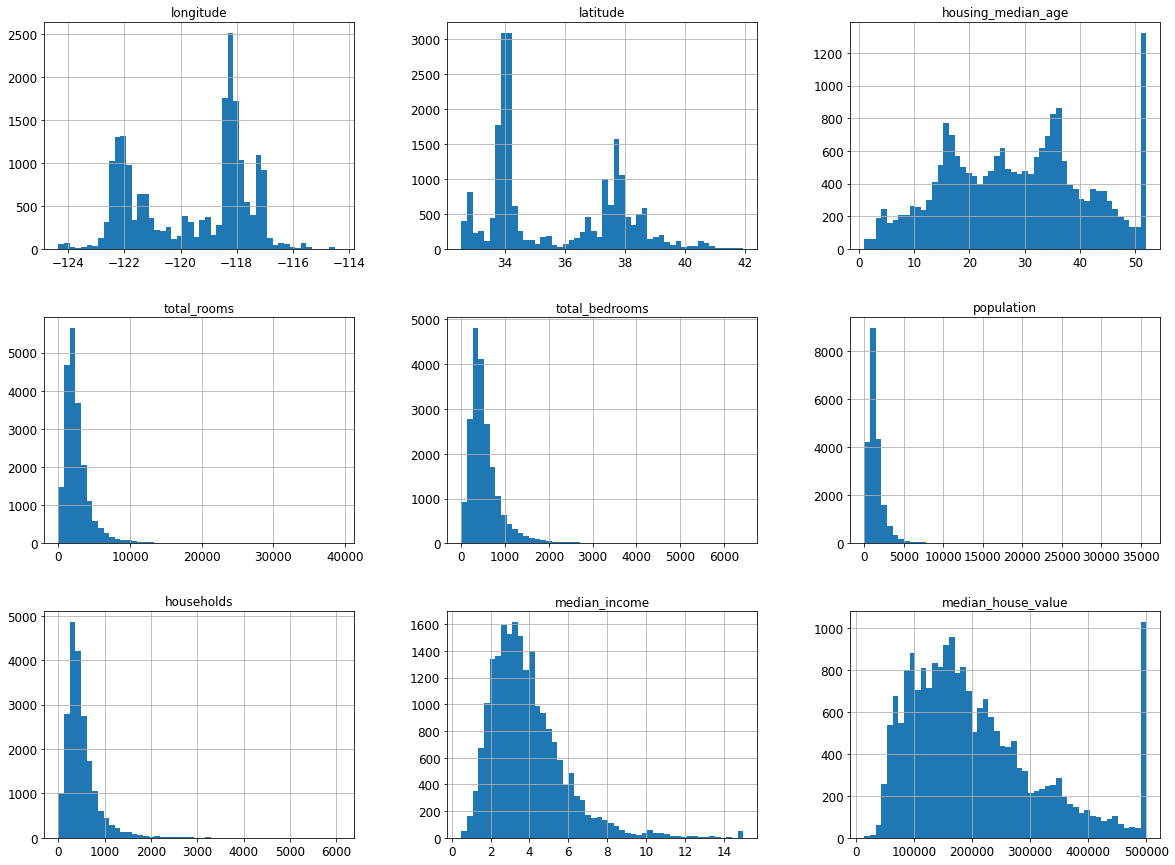

In [10]:
housing.hist(bins=50, figsize=(20, 15))

#### Remarques :
* `median_income` n'est pas en dollars US (On apprend en consultant les auteurs du _dataset_ que les valeurs ont été mises à l'échelles et _capées_ entre 0.49999 et 15.0001, c'est à dire que toutes les valeurs inférieures à 0.49999 seront enregitrées à 0.49999 et toutes les valeurs supérieures à 15.0001 seront enregistrées à 15.0001).
* `housing_median_age` et `median_house_value` sont capées également. C'est un problème en ce qui concerne la deuxième de ces _features_ car c'est notre variable-cible. Notre modèle devra apprendre à respecter ce _caping_ et le client devra être informé : cette limite convient-elle à son besoin ? Si tel n'est pas le cas, on pourra essayer de collecter d'autres données ou retirer les valeurs concernées du _dataset_.
* Les échelles sont très différentes d'une _feature_ à l'autre. Un _scaling_ sera sans doute nécessaire pour obtenir un modèle performant.
* plusieurs histogrammes sont _tail heavy_ alors que les algorithmes de _ML_ fonctionnent en général mieux avec les _courbes en cloche_.

### Les mauvaises pratiques décrites dans le texte du prosit
Voici ce qui a été fait par l'acteur du prosit:
- supprimer les variables pour lesquelles il y a des données manquantes
- supprimer les variables qualitatives
- travailler sur le jeu de données complet ce qui ne permettra pas de tester derrière la qualité des résultats obtenus (si on souhaite faire une classification ou une régression)

En supprimant des variables, on perd peut-être des informations importantes.

#### Classification Ascendante Hiérarchique

Ne soyez pas surpris du temps pris avant un affichage des résultats... On utilise tout le jeu de données et l'algorithme n'est pas le plus adapté pour de gros jeux de données.
Notez que l'algorithme utilise la distance euclidienne (euclidian) pour mesurer la distance entre 2 points (block groups au niveau métier) et que la méthode de Ward (ward) est utilisée pour minimiser la distance entre les points à l'intérieur d'un même regroupement.


In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

X = housing.copy() # A new copy of data set
X.drop("ocean_proximity", axis=1, inplace=True) # Not numerical
X.drop("total_bedrooms", axis=1, inplace=True) # Missing values
X.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462,342200.0


Construction et affichage du dendragramme résultant:

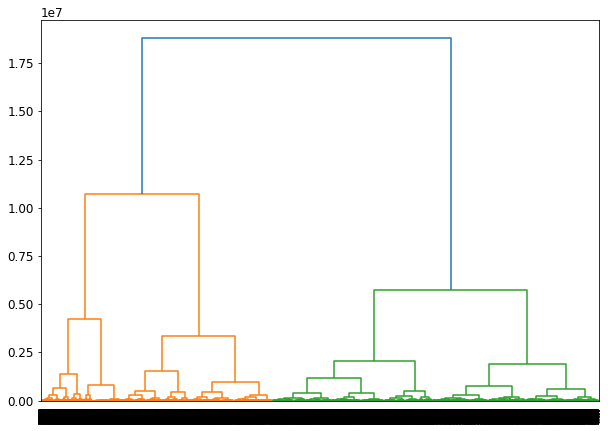

In [12]:
plt.figure(figsize=(10, 7))
dendrogram(linkage(X, method='ward'), orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

Représentation en fonction de la longitude et de la latitude des 2 classes (n_clusters) que l'on a choisi de retenir. Par rapport au dendrogramme, in supprime les branches dessinées en bleu.

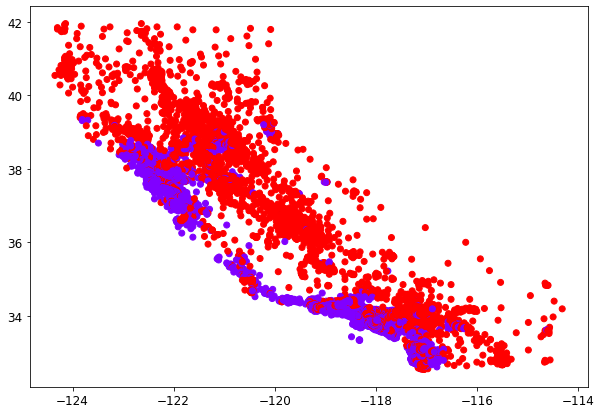

In [13]:
cluster = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
cluster.fit_predict(X)
plt.figure(figsize=(10, 7))
plt.scatter(X['longitude'],X['latitude'], c=cluster.labels_, cmap='rainbow')
plt.show()

### Création d'un jeu de test

#### Jeu de test aléatoire
Nous avons déjà trop observé ce jeu de données : il est grand temps d'en réserver un échantillon de test. En effet, votre cerveau, remarquable machine à apprendre, commence déjà à établir des _patrons_. Celà pourrait biaiser la démarche menant au choix du modèle et aboutir à du _surapprentissage_. On ne doit utiliser le jeu de test que lorsqu'on est proche du but et assez convaincu que le modèle qu'on a établi est le bon. Dans le cas contraire, on fait du _data snooping_. Note pour plus tard :

> Pas de _data snooping_ !

Créer un jeu de test est simple : on met aléatoirement 20% des données de côtés.

L'exemple de code ci-dessous permet de comprendre l'approche mais le framework scikit-learn contient une fonction pour cet usage.
On utilise, l'objet [`numpy.random`](https://numpy.org/doc/stable/reference/random/index.html) permettant de générer une séquence de bits aléatoires qui est utilisée pour générer des nombres aléatoires.
En phase de développement, pour reproduire le même comportement d'une exécution à une autre de notre script, il est d'usage de définir manuellement une graine de départ (seed) pour cette séquence aléatoire. Cela permet de valider son développement sans que la séquence de nombres aléatoires ne vienne compliquer l'interprétation entre deux exécutions. La valeur classiquement utilisée pour cette graine est [42](https://medium.com/@leticia.b/the-story-of-seed-42-874953452b94) (revenir sur la partie _Préparation de l'environnement_ pour constater).  

In [14]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [15]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


Dans les faits, certaines librairies n'utilisent pas encore les générateurs de séquence de bits aléatoire inégrés récemment dans numpy ce qui peut amener à un comportement de votre script plus difficilement interprétable d'une exécution à l'autre.

#### Utilisation d'une fonction de hachage

Ci-dessous, on définit une fonction `split_train_test_by_id` construisant un jeu de test en hachant un identifiant unique à chaque ligne (ex : le numéro de la ligne). Le résultat de ce _hash_ est mappé sur l'ensemble booléen $\{0,1\}$ en respectant le ratio afin de décider la destination de l'enregistrement (test ou entraînement).

In [16]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

#### Utilisation de `scikit-learn`

La bibliothèque de _machine learning_ [`scikit-learn`](https://scikit-learn.org/) propose une fonction [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) réalisant ce traîtement. Son utilisation est fortement conseillée maintenant que nous avons compris son fonctionnement.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train_test_split(housing)

[       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 792      -122.09     37.64                36.0       1885.0           307.0   
 20102    -120.13     37.93                 5.0        111.0            26.0   
 9831     -121.93     36.63                28.0       3983.0           852.0   
 1160     -121.53     39.52                24.0       1028.0           185.0   
 11097    -117.88     33.83                22.0       3522.0           543.0   
 ...          ...       ...                 ...          ...             ...   
 8353     -118.32     33.95                44.0       2023.0           325.0   
 10552    -117.70     33.65                16.0       3388.0           492.0   
 12638    -121.45     38.54                38.0       1865.0           384.0   
 19353    -122.87     38.68                32.0       4073.0           718.0   
 17297    -119.52     34.41                20.0       4489.0           800.0   
 
        population  households  median

In [19]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
15387,-117.05,33.29,17.0,1800.0,312.0,891.0,281.0,7.0177,267600.0,<1H OCEAN
1659,-121.91,37.93,13.0,1610.0,198.0,703.0,217.0,8.7059,329400.0,INLAND
14480,-117.25,32.82,19.0,5255.0,762.0,1773.0,725.0,7.8013,474000.0,NEAR OCEAN
10991,-117.81,33.73,19.0,4022.0,975.0,2334.0,954.0,3.0305,140600.0,<1H OCEAN
9332,-122.64,38.01,36.0,1336.0,258.0,678.0,249.0,5.5789,292000.0,NEAR OCEAN


Il faut s'assurer de ne pas introduire de biais statistique, d'une part, et de respecter le [_stratified sampling_](https://en.wikipedia.org/wiki/Stratified_sampling). Par exemple, dans le cas de notre exemple, on va tâcher d'avoir une distribution représentative du `median_income`. Pour éviter les biais de sous-représentation ou sur-représentation, on essaye d'avoir un nombre limité de strates (strates que l'on préfèrera donc assez larges).

#### Echantillonage stratifié

Après discussion avec des experts métiers, nous sommes convaincus que le revenu moyen est une variable-clef. Nous désirons effectuer un échantillonage où les jeux d'entraînement et de test respectent les proportions de représentation des différentes catégories de salaire. Pour celà, nous commençons par créer une variable `income_cat`, pendant catégoriel de la variable numérique `median_income`

In [20]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # replace where false

On peut observer les effectifs de chaque catégories.

<Axes: >

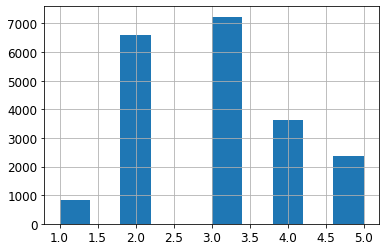

In [21]:
housing["income_cat"].hist()

On peut maintenant utiliser [`StratifiedShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) pour échantillonner le jeu de données en respectant notre contrainte :

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    print(train_index, test_index) # 1 seul tour de boucle si n_splits = 1
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

[12655 15502  2908 ... 19263 19140 19773] [ 5241 17352  3505 ... 17223 10786  3965]


<Axes: >

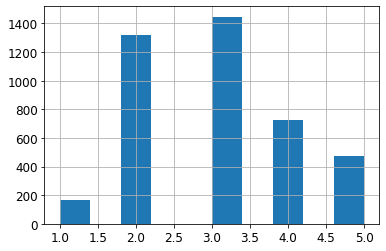

In [23]:
strat_test_set["income_cat"].hist()

Notre échantillonnage respecte bien les proportions du jeu initial. On n'a plus besoin de la colonne `income_cat` : on la supprime avec [`drop()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html).

In [24]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop(columns='income_cat', inplace=True)

In [25]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN


Remarque : si le jeu de données était plus volumineux, on pourrait être amené à devoir créer un jeu d'exploration. Ce n'est pas la peine ici.

### Explorer le jeu de données

Notre jeu de test étant constitué, nous pouvons commencer l'exploration. Nous allons travailler sur une copie du jeu d'entraînement pour éviter toute mauvaise surprise.

In [26]:
housing = strat_train_set.copy()

#### Visualisation de données géographiques

La bibliothèque [`matplotlib`]() permet de représenter des données sous formes graphique. On peut s'y initier _via_ ce [tutoriel](https://www.python-course.eu/matplotlib.php).

Les coordonnées géographiques de nos enregistrements étant connues, on a envie de les représenter sur le plan :

<Axes: xlabel='longitude', ylabel='latitude'>

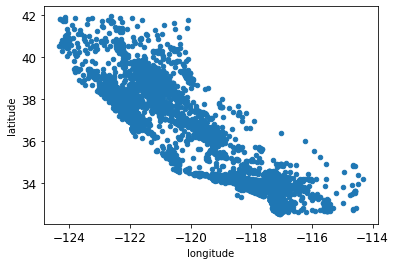

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Ce n'est pas très lisible, on aimerait jouer sur la transparence des points pour mettre en évidence les densité de point :

<Axes: xlabel='longitude', ylabel='latitude'>

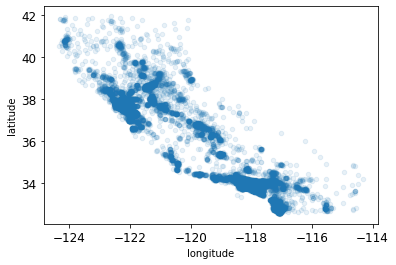

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

On peut faire varier à loisir la taille de nos marqueurs (option `s`) et leur couleur (option `c` : on utilise une palette `cmap` prédéfinie nommée `jet`). Ici on veut distinguer les zones en fonction de leur population et de leur revenu moyen. 

Saving figure housing_prices_scatterplot


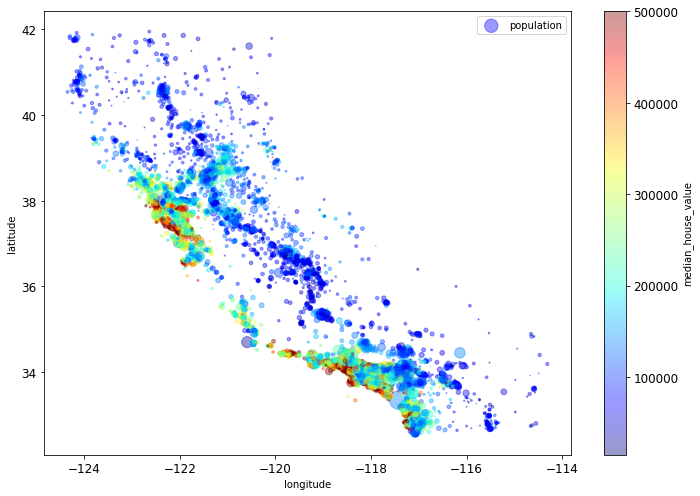

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot") # Produira une erreur si le répertoire n'existe pas

On constate que la situation géographique importe. On peut imaginer que la valeur moyenne d'une maison est corrélée à la proximité à l'océan, d'une part, et qu'un algorithme de _clustering_, d'autre part, donnerait des résultat intéressants.

Si nous souhaitions visualiser d'autres données géographique. Nous pourrions utiliser [une autre palette](https://matplotlib.org/examples/color/colormaps_reference.html) en fonction de ce que nous voudrions démontrer. Dans l'exemple précédent, les couleurs sont sur un axe chaud/froid ; une palette prise au hasard telle que `cubehelix` aurait eu un rendu moins facile à interpréter.  La couleur n'est pas à négliger lorsqu'il s'agit de mettre une idée en évidence.

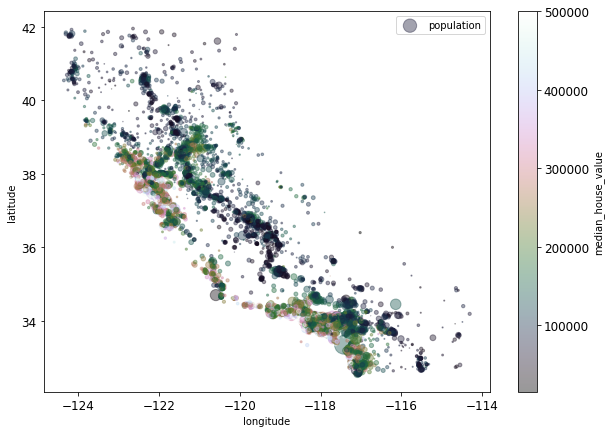

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("cubehelix"), colorbar=True,
    sharex=False)
plt.legend()

#### Recherche de corrélation

Les variables d'un jeu de données peuvent être liées deux à deux (plus ou moins fortement, positivement ou négativement), c'est pourquoi on calcule leur [corrélation](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)).

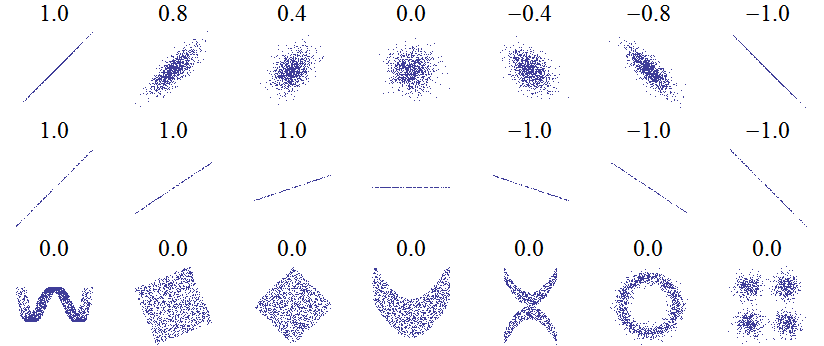

In [31]:
from IPython.display import Image
Image("https://upload.wikimedia.org/wikipedia/commons/0/02/Correlation_examples.png")

Pour un jeu de données de petite taille tel que le notre, on peut calculer la matrice de corrélation avec [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) et en afficher une série, par exemple celle correspondant à la variable `median_income` :

In [32]:
corr_matrix = housing.corr()
corr_matrix["median_income"]

C:\Users\mathi\AppData\Local\Temp\ipykernel_5536\2166018267.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


longitude            -0.019615
latitude             -0.075146
housing_median_age   -0.111315
total_rooms           0.200133
total_bedrooms       -0.009643
population            0.002421
households            0.010869
median_income         1.000000
median_house_value    0.687151
Name: median_income, dtype: float64

[`scatter_matrix`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.plotting.scatter_matrix.html) permet de visualiser les relations entre variables ainsi qu'un histogramme en _bonus_ pour chaque variable sur la diagonale :

Saving figure scatter_matrix_plot


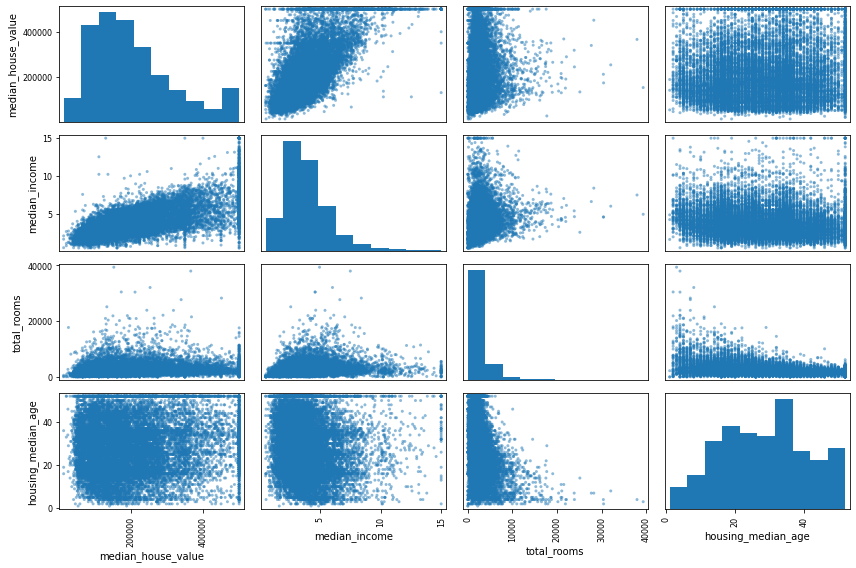

In [33]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

On remarque d'ores et déjà une corrélation positive forte entre `median_income` et `median_house_value`. C'est prometteur.

Zoomons sur ce candidat :

Saving figure income_vs_house_value_scatterplot


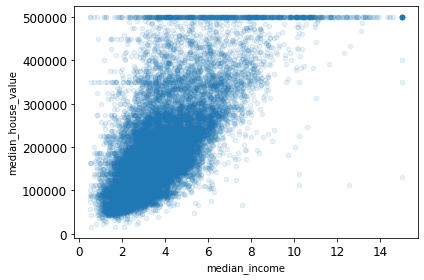

In [34]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

save_fig("income_vs_house_value_scatterplot")

On voit quelques pistes d'amélioration :
- Les lignes horizontales du dernier graphique pourraient correspondre aux cases d'un questionnaire. Il serait légitime de supprimer les valeurs correspondantes si l'on voulait obtenir un résultat optimal.
- Certaines distributions sont _tail-heavy_, on pourrait tenter de les transformer, pourquoi pas en utilisant un _logarithme_.
- On a aussi envie de combiner certains attributs. En effet, par exemple, il semble logique de rapprocher le nombre de pièces dans le district(`total_rooms`) du nombre total de logements dans ce district (`households`).


#### Combinaison d'attributs

Comme suggéré précédemment, on va créer de nouvelles variables `rooms_per_household`, `bedrooms_per_room` et `population_per_household` et visualiser leur corrélation à `median_house_value`.

In [35]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [36]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=True)

C:\Users\mathi\AppData\Local\Temp\ipykernel_5536\1929191059.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


bedrooms_per_room          -0.259952
latitude                   -0.142673
longitude                  -0.047466
population                 -0.026882
population_per_household   -0.021991
total_bedrooms              0.047781
households                  0.064590
housing_median_age          0.114146
total_rooms                 0.135140
rooms_per_household         0.146255
median_income               0.687151
median_house_value          1.000000
Name: median_house_value, dtype: float64

Pas mal ! On obtient une corrélation négative assez prononcée avec `bedrooms_per_rooms`.
On va maintenant préparer les données pour l'apprentissage automatique.

## Préparation des données pour les algorithmes de ML

Il est indispensable de scripter cette préparation pour plusieurs raisons :
* Afin de la rendre reproductible, par exemple si on obtient une version plus récente du jeu initial.
* Afin de se constituer une bibliothèque d'utilitaires.
* Afin que ces transformation puissent être utilisées _à chaud_ en production sans intervention humaine.
* Afin d'effectuer des bancs d'essai entre plusieurs stratégies de péparation.

On va commencer par scinder le jeu de données. D'une part, les variables-cibles, ou étiquettes, souvent notées $\Y$ (une seule ici donc $\y$) et de l'autre les autres variables notées $\X$. On obtiendra `housing_labels` et `housing`.

In [37]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Nettoyage des données

##### Valeurs manquantes dans `total_bedrooms`

On a pu remarquer plus haut, en appelant la méthode `info()`, que la _feature_ `total_bedrooms` comptait des valeurs manquantes.

In [38]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


On a plusieurs options en cas de valeur manquante:
1. Supprimer l'instance
1. Supprimer la _feature_
1. Remplacer par une valeur (0, médiane, _etc_.)

On pourrait utiliser [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna), [`drop()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html#pandas.DataFrame.drop), [`fillna()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna)

In [39]:
# option 1 :
# housing.dropna(subset=["total_bedrooms"])
# option 2 :
# housing.drop("total_bedrooms", axis=1)
# option 3 :
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

On teste ces options sur l'échantillon concerné `sample_incomplete_rows`.

In [40]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [41]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"]) # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [42]:
sample_incomplete_rows.drop("total_bedrooms", axis=1) # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [43]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


Pour plus de commodité, `scikit-learn` propose une classe dédiée à ce genre de traitements : [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html).

In [44]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Attention : cette stratégie ne s'applique qu'aux variables numériques donc on doit _dropper_ les autres pour le traitement.

In [69]:
#housing_num = housing.drop('ocean_proximity', axis=1)
# Plus général :
housing_num = housing.select_dtypes(include=[np.number]) 

On peut maintenant _entraîner_ l'`Imputer` avec la méthode `fit()`.

In [46]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

> l'_API_ de `scikit_learn` est telle que les objets, qu'il soient des _estimateurs_, des _transformeurs_ ou des prédicteurs possèdent une syntaxe commune intuitive. Pour approfondir, la lecture de _API design for machine learning software: experiences from the scikit-learn project_ [Buitinck _et al._](https://hal.inria.fr/hal-00856511/file/paper.pdf) est envisageable.

L'`Imputer` a calculé la médiane pour chaque variable et l'a stockée dans son attribut `statistics_`.

In [47]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [48]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

On peut alors transformer les données avec la méthode `transform()` de l'`Imputer` :

In [49]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)

Le résultat est un [`array`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.array.html) [`Numpy`](http://www.numpy.org/). On va en refaire un `DataFrame` en récupérant les noms de colonnes dans `housing_num`.

In [50]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


##### Attributs textuels et catégories

On s'intéresse maintenant aux variables catégorielles.

##### Numérisation

In [74]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


Les algorithmes de _ML_ étant plus à l'aise avec des nombres, on _mappe_ ces catégories sur des nombres avec `OrdinalEncoder`. On utilise la méthode `fit_transform` qui enchaîne `fit` et `transform` comme son nom l'indique.

In [52]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

L'`encoder` donne accès au mapping des catégories :

In [53]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

> Attention ! Des algorithmes de ML peuvent considérer que des valeurs numériques telles que $1$ et $2$ plus proches l'une de l'autre que ne le sont $1$ et $4$. Ce n'est _a priori_ pas vrai ici si on mappe les catégories trivialement sur `[0,1,2,3,4]`. Le _1-hot encoding_ palie ce problème. Chaque catégorie va donner naissance à une nouvelle variable booléenne.

##### _One-hot encoding_

Quand une variables n'est pas ordinale, cette solution va créer des variables supplémentaires dans le jeu de donnée pour représenter chacune des catégories.
Dans le cas de notre jeu de données, cela peut être un choix ou on peut utiliser l'approche précédente en précisant l'ordre des catégories. Par exemple: 'INLAND' > '<1H OCEAN' > 'NEAR OCEAN' > 'NEAR BAY' > 'ISLAND'.
L'expertise métier peut aider à faire ce type de choix selon le contexte.

In [54]:
from sklearn.preprocessing import OneHotEncoder

On utilise la méthode `fit_transform` du [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) qui retourne une `sparse matrix`, version compressée qu'on peut révéler avec la méthode `toarray()`.

In [55]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # array creux par défaut

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [56]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Une alternative est d'utiliser l'option `sparse` de l'encodeur.

In [57]:
cat_encoder = OneHotEncoder(sparse_output=True)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # array dense
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

On a accès aux catégories _via_ l'attribut `categories_` de notre encodeur.

In [58]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

##### Transformations _ad hoc_

Il sera parfois nécessaire d'implémenter nos propres transformations. Rester en cohérence avec l'_API_ de `sci-kit learn` nous permettra de constituer des _pipeline_ de traitement homogènes.

`scikit-learn` étant basé sur le _duck typing_, l'implémentation d'un transformer sera celle d'une classe comportant ces méthodes :
- `fit()` (retournant souvent `self`)
- `transform()`
- `fit_transform()` (obtenue gratuitement en ajoutant `TransformerMixin` aux classes de base)

L'ajout de la classe `BaseEstimator` aux classes de base permettra plus tard le tuning automatisé des _hyper-paramètres_. Elle a pour effet d'ajouter les méthodes `get_params` et `set_params` à condition d'avoir un nombre fixe de paramètres dans le constructeur (on évitera `*args` et `**kwargs`).

L'exemple ci-dessous nous sert à créer les variables combinées :

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin

# index pour chaque colonne
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

> Remarque : ici notre _transformer_ possède un unique hyper-paramètre `add_bedrooms_per_room`. Il sera facile de modifier notre chaîne de traitement pour savoir si, oui ou non, ce paramètre doit être ajouté. Les paramètres permettent de retarder, voire d'automatiser, les prises de décision de ce genre.

In [60]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [61]:
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

On peut reconstruire un `DataFrame` avec en-têtes.

In [62]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
4,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


##### _Feature scaling_

Les algos de ML ne marchent pas bien quand les _features_ ont des échelles très différentes (ex. `number_of_rooms` entre 0 et 40000 alors que `median_income` entre 0 et 15). Les stratégies pour y remédier sont : _min-max scaling_ et _standardization_.
* min-max scaling : _mappe_ [min,max] sur[0,1] ([`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html))
* standardization : _mappe_ la moyenne sur zero avec variance unitaire. ([`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html))

La deuxième option est moins sensible aux [_valeurs aberrantes_](https://fr.wikipedia.org/wiki/Donn%C3%A9e_aberrante).


> C'est bien en fonction des données du jeu d'entraînement (seulement) qu'on effectura les mises à l'échelle.

##### _Pipeline_ de transformation

Nous désirons pouvoir créer un _transformer_ qui serait la résultante de tous les autres (réalisés dans le bon ordre). Par exemple, pour les attributs numériques :

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Il serait encore mieux de n'avoir pas à extraire manuellement les valeurs numériques. On aimerait pouvoir alimenter le _pipeline_ directement avec le `DataFrame` initial. On va utiliser [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) pour créer l'embranchement.

In [64]:
from sklearn.compose import ColumnTransformer

In [65]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [66]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [67]:
housing_prepared.shape

(16512, 16)

Nous en avons terminé avec l'étape de préparation des données. Définissez donc votre pipeline pour préparer vos données afin qu'elles soient le plus adaptées possible pour l'exécution de l'algorithme des K-Means. Vous pourrez passer ensuite à l'apprentissage !